# Blackjack Simulation
## Practical Python and data science learning by building a Blackjack simulator
### (Bonus: Get a deeper understanding of win rates through statistical outcomes)

Here's the link that shows the strategy we'll be using:

https://wizardofodds.com/games/blackjack/strategy/4-decks/?source=post_page---------------------------

### What is Blackjack? 
Blackjack, also known as Twenty-One, is a popular card game. It is a comparing card game between players and a dealer, where each player in turn competes against the dealer, but the players do not play against each other. Players win the game by one of the following: 
- Get 21 points on the player's first two cards (called a "blackjack"), without a dealer blackjack
- Reach a final score higher than the dealer without excedding 21
- Let the dealer draw additional cards until their hand exceeds 21 ("busted")

The players can see one of the dealer's card before making their decision, whereas the dealer acts independent of the player's cards, generally continuing until its score hits 17. 

Each number card is worth its number, beside a face card or an Ace. An Ace is worth 1 or 11 and each face card is worth 10. 

## Goal of this project: 
The main goal of this project is to investigate the win rates of Blackjack by simulating games using Python.
We'll build several classes to represent the fundamental ingredients for a Blackjack game. In the last step of the project, we'll actually run a large number of simulation to look at the average win rates of the player. 

In [2]:
import numpy as np
import random
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
class Card: 
    '''Card class represents playing cards with three attributes: Rank, Suit, and if it's the hole card. 
    '''
    _card_values={'A': [1, 11], 'J': [10], 'Q': [10], 'K': [10]}
    _card_values.update({str(n): [n] for n in range(2, 11)})

    def __init__(self, rank, suit, hole=False):
        self._rank=rank
        self._suit=suit
        self._hole=hole
        if self._hole:
            self._values=0
        else: 
            self._values=Card._card_values[rank]

    @property
    def values(self):
        return self._values
    
    @property
    def rank(self):
        return self._rank
    
    @property
    def card_rep(self):
        if self._hole==True:
            return 'Hole'
        else:
            return self._rank +' ' + self._suit
    
    def __eq__(self, other):
        return self._rank==other._rank and self._suit==other._suit
    
class Shoe:
    '''Shoe class represents deck or decks of Cards. The shoe class is responsible for shuffling the cards and dealing the cards
    '''
    _possible_ranks=['A'] + [str(n) for n in range(2, 11)] + ['J', 'Q', 'K']
    _possible_suits=['SPADE', 'HEART', 'DIAMOND', 'CLUB']
    
    def __init__(self, num_of_decks=1):
        if num_of_decks <= 0:
            raise ValueError('Must have at least one deck')
        self._cards=[]
        this_shoe=[itertools.product(Shoe._possible_suits, Shoe._possible_ranks) for n in range(num_of_decks)]
        for each_deck in this_shoe:
            for suit, rank in each_deck:
                self._cards.append(Card(rank, suit))
    
    def shuffle(self):
        random.shuffle(self._cards)
        
    @property
    def num_of_cards(self):
        return self._num_of_cards
        
    def deal_one(self):
        if (len(self._cards)==0):
            raise ValueError('No more cards')
        else: 
            return self._cards.pop()
    
    @property
    def num_of_cards(self):
        return len(self._cards)
    
    def remove_card(self, card):
        self._cards.remove(card)
    
class Hand:
    '''Hand class represents the two initial cards that are dealt and any additional cards. The Hand class is responsible for calculating the scores. 
    '''
    def __init__(self): 
        self._cards=[]
        
    @property    
    def num_of_cards(self):
        return len(self._cards)
    
    @property
    def scores(self): 
        possible_scores=[sum(each_pair) for each_pair in itertools.product(*[each_card.values for each_card in self._cards]) if sum(each_pair) <=21]
        return possible_scores
        
    @property
    def is_blackjack(self):
        return self.num_of_cards==2 and self.best_score==21
    
    @property
    def is_soft(self):
        return len([n for n in self.scores if n<=21])>1
        
    def add_card(self, card, hole=False):
        card._hole=hole
        self._cards.append(card)
    
    @property
    def is_in_play(self):
        return len(self.scores)>0 and not self.is_blackjack
    
    def show_hand(self):
        for each_card in self._cards:
            print(each_card.card_rep)
        print('Possible scores: ', self.scores, '\n')
    
    @property
    def best_score(self):
        if len(self.scores)==0:
            return 0
        return max(self.scores)
    
    def unhole(self):
        for each_card in self._cards:
            each_card._hole=False
    
class Game:
    '''Game class represents a player vs. dealer game. The Game class is responsible for progressing through each Hand and calculating the winner of each game. 
    '''
    def __init__(self, show=False):
        self._shoe=Shoe(1)
        self._shoe.shuffle()
        self._player_hand=Hand()
        self._dealer_hand=Hand()
        self._show=show
        self._player_hand.add_card(self._shoe.deal_one())
        self._player_hand.add_card(self._shoe.deal_one())
        self._dealer_face_up=self._shoe.deal_one()
        self._dealer_hand.add_card(self._dealer_face_up)
        self._dealer_hand.add_card(self._shoe.deal_one(), True)
        self.update()

    def update(self):
        if self._show: 
            print('Player hand:')
            self._player_hand.show_hand()
            if self._player_hand.is_blackjack: 
                print('Blackjack!')
            print('Dealer hand:')
            self._dealer_hand.show_hand()
            print(self._shoe.num_of_cards, 'cards left in the shoe')
    
    @property
    def player_score(self):
        return self._player_hand.best_score
    
    @property
    def dealer_card(self):
        return self._dealer_face_up.rank
        
    def player_action(self):
        if self._player_hand.is_in_play and not self._player_hand.is_blackjack and not self._dealer_hand.is_blackjack:
            if max(self._player_hand.scores)<17:
                self._player_hand.add_card(self._shoe.deal_one())
                self.update()
                self.player_action()
        
    def dealer_action(self):
        if self._player_hand.is_in_play and not self._player_hand.is_blackjack and not self._dealer_hand.is_blackjack:            
            self._dealer_hand.unhole()
            if self._dealer_hand.is_in_play:
                if max(self._dealer_hand.scores)<17:
                    self._dealer_hand.add_card(self._shoe.deal_one())
                    self.update()
                    self.dealer_action()
    
    @property
    def winner(self):
        if self._dealer_hand.is_blackjack and self._player_hand.is_blackjack:
            return 'T'
        elif self._player_hand.is_blackjack: 
            return 'P'
        elif self._dealer_hand.is_blackjack:
            return 'D'
        elif self._player_hand.best_score>self._dealer_hand.best_score: 
            return 'P'
        elif self._player_hand.best_score==self._dealer_hand.best_score:
            return 'T'
        else: 
            return 'D'

In [31]:
num_of_sim=100000
possible_player_hand=[str(n) for n in range(4, 22)]
possible_dealer_hand=['A']+[str(n) for n in range(2, 11)]+['J', 'Q', 'K']
player_win_counts=pd.DataFrame(columns=possible_dealer_hand, index=possible_player_hand)
player_win_counts[:]=0
push_counts=pd.DataFrame(columns=possible_dealer_hand, index=possible_player_hand)
push_counts[:]=0
dealer_win_counts=pd.DataFrame(columns=possible_dealer_hand, index=possible_player_hand)
dealer_win_counts[:]=0
total_counts_by_hand=pd.DataFrame(columns=possible_dealer_hand, index=possible_player_hand)
total_counts_by_hand[:]=0
for each_game in range(0, num_of_sim):
    sim_game=Game(show=False)
    player_score=sim_game.player_score
    dealer_card=sim_game.dealer_card
    sim_game.player_action()
    sim_game.dealer_action()
    total_counts_by_hand[dealer_card][str(player_score)]=total_counts_by_hand[dealer_card][str(player_score)]+1
    if sim_game.winner=='P':
        player_win_counts[dealer_card][str(player_score)]=player_win_counts[dealer_card][str(player_score)]+1
    elif sim_game.winner=='T':
        push_counts[dealer_card][str(player_score)]=push_counts[dealer_card][str(player_score)]+1
    elif sim_game.winner=='D':
        dealer_win_counts[dealer_card][str(player_score)]=dealer_win_counts[dealer_card][str(player_score)]+1

In [46]:
# print('Player counts:\n', player_win_counts)
print('Player wins ', str(player_win_counts.values.sum()/num_of_sim), ' of the time\n')
# print('Push counts:\n', push_counts.sum())
print('Push ', str(push_counts.values.sum()/num_of_sim), ' of the time\n')
# print('Dealer counts:\n', dealer_win_counts)
print('Dealer wins: ', str(dealer_win_counts.values.sum()/num_of_sim), ' of the time\n')
# print(dealer_win_counts.sum().sum())
# print(total_counts_by_hand.sum().sum())
# print('Total of', num_of_sim, 'games\n')

Player wins  0.4122  of the time

Push  0.09452  of the time

Dealer wins:  0.49328  of the time



In [33]:
# Summary Stats
# print('This is the chances of being dealt each hand: \()')
# print(str(((total_counts_by_hand.sum(axis=1)/num_of_sim)*100).round(2)))
# print('This is the chances of winning for each hand a player is dealt:')
# print(str(((player_win_counts.sum(axis=1)/total_counts_by_hand.sum(axis=1))*100).round(2)))

### The results converges when the simulation is run about ~100,000 times. On average, the Dealer will win 49% of the time, and the Player will win ~41% of the time. ~9% of the time, the Player will push with the Dealer. 

### Some more interesting findings: 
-  On average: 
    -  a Player is dealt a 20 10% of the time, about the same as getting a 12 or 13. 
    -  a Player only has a ~50% chance of winning if dealt a 10 or 11, vs. a ~70% of winning if dealt a 20. That number drops if the player doubles down (gets only one card)
    -  a Player has <1% chance of pushing with the Dealer if dealt a 21. 

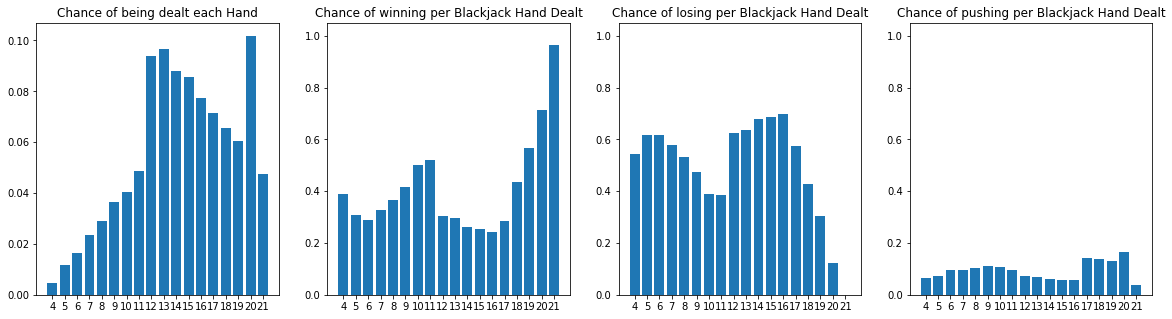

In [35]:
fig, (ax_1, ax_2, ax_3, ax_4)=plt.subplots(1, 4, sharex=True, figsize=(20, 5))

ax_1.bar(x=total_counts_by_hand.index, height=(total_counts_by_hand.sum(axis=1)/num_of_sim))
ax_1.set_title('Chance of being dealt each Hand')

ax_2.bar(x=total_counts_by_hand.index, height=player_win_counts.sum(axis=1)/total_counts_by_hand.sum(axis=1))
ax_2.set_title('Chance of winning per Blackjack Hand Dealt')
ax_2.set_ylim([0, 1.05])

ax_3.bar(x=total_counts_by_hand.index, height=dealer_win_counts.sum(axis=1)/total_counts_by_hand.sum(axis=1))
ax_3.set_title('Chance of losing per Blackjack Hand Dealt')
ax_3.set_ylim([0, 1.05])

ax_4.bar(x=total_counts_by_hand.index, height=push_counts.sum(axis=1)/total_counts_by_hand.sum(axis=1))
ax_4.set_title('Chance of pushing per Blackjack Hand Dealt')
ax_4.set_ylim([0, 1.05])

plt.show()

### As it turns out, the Dealer has an advantage when both sides play with the same exact strategy (hit soft 16)
Of course there are ways to lower the advance of the house. In future edits of this project - we'll modify the strategy. I'd love to try to simulate random player actions and train a Machine Learning model to learn the best strategy